### gQuant – GPU Accelerated framework for Quantitative Analyst Tasks
### gQuant background
By definition, Quantitative finance is the use of mathematical models and large datasets to analyze financial markets and securities. It is one of the fields that requires massive computations to extract insight from the data. A lot of data science toolkits are developed to help data scientists to manipulate the data. It starts with scalar number computations at the beginning. Later, the development of Numpy library helps to operate the numbers at vectors. The popular Pandas library operates at a group of vectors (dataframe) level. The convenience of manipulating the data at a high level brings productivity gain for the data scientists in the quantitative finance. However, recently more and more data are collected. And more and more machine learning and statistics models are developed.  This brings a few challenges that traditional data science library is hard to deal with:

It is very time consuming for the CPU to crunch massive amount of data and compute the complicated data science models. 
Large data set requires distributed computation, which is too complicated for data scientist to adopt. 
The quantitative workflow becomes more complicated than before. It integrates massive data from different sources and requires a lot of iterations to find the best approach. 
gQuant is developed to handle all these above challenges by organizing a group of dataframes in a graph. It introduces the idea of "dataframe-flow" that manipulate the data at the graph level. The dataframe manipulation is organized into an acyclic directed graph, where the nodes are dataframe processors and the edges are the directions of passing resulting dataframes. This graph approach organizes the quant's workflow at a high level that addresses the complicated workflow challenge. gQuant is built on top of the NVIDIA's RAPIDS library, which can passes GPU cuDF dataframes in the graph. In this way, all data are stored in the GPU memory and manipulated in the GPU. We can get orders of magnitude performance boosts compared to CPU. gQuant dataframe-flow is dataframe agnostic. Switching to dask_cudf dataframe, the computation  automatically becomes multiple nodes and multiple GPUs distributed computation. 

In this blog, we will use a simple toy example to show how easy it is to accelerate the quant workflow in the GPU.

### Environment Preparation

In [1]:
import sys
sys.path.append('..')

import warnings
from gquant.dataframe_flow import run, load_workflow, viz_graph, get_graph, Node
import nxpd
import ipywidgets as widgets
from nxpd import draw
import os

warnings.simplefilter("ignore")

Start the Dask local cluster environment for distrubuted computation:

In [2]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33374 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 536.39 GB


The Dask status page can be popped up in the brwoser by following javascript commands:

In [3]:
from IPython.display import HTML
javascript = """
<script type="text/Javascript">
    function check_status(){
        var url = document.location.href;
        var index = url.indexOf(':8888');
        var status = url.substr(0, index)+":8787";
        window.open(status,'_blank');
    }
    check_status();
</script>
"""
HTML(javascript)

Define some constants for the data filters. If using GPU of 32G memory, you can safely set the `min_volume` to 5.0

In [4]:
min_volume = 400.0
min_rate = -10.0
max_rate = 10.0

### The toy example
To mimic the end-to-end quantitative analyst task, we are going to backtest a simple mean reversion trading strategy. The workflow includes following steps:

1. Load the 5000 end-of-day stocks CSV data into the dataframe

2. Add rate of return feature to the dataframe.

3. Clean up the data by removing low volume stocks and extreme rate of returns stocks.

4. Compute the slow and fast exponential moving average and compute the trading signal based on it

5. Run backtesting and compute the returns from this strategy for each of the days and stock symbols 

6. Run a simple portfolio optimization by averaging the stocks together for each of the trading days.

7. Compute the sharpe ratio and cumulative return results

The whole workflow can be organized into a computation graph, which are fully described in a yaml file. Here is snippet of the yaml file:

In [5]:
!head -n 29 ../task_example/port_trade.yaml

- id: node_csvdata
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: node_sort
  type: SortNode
  conf:
    keys:
      - asset
      - datetime
  inputs:
    - node_csvdata
- id: node_addReturn
  type: ReturnFeatureNode
  conf: {}
  inputs:
    - node_sort
- id: node_addIndicator
  type: AssetIndicatorNode
  conf: {}
  inputs:
    - node_addReturn
- id: node_volumeMean
  type: AverageNode
  conf:
    column: volume
  inputs: 
    - node_addIndicator


Each nodes has a unique id, a node type, configuration parameters and input nodes ids. gQuant takes this yaml file, wires it into a graph to visualize it.

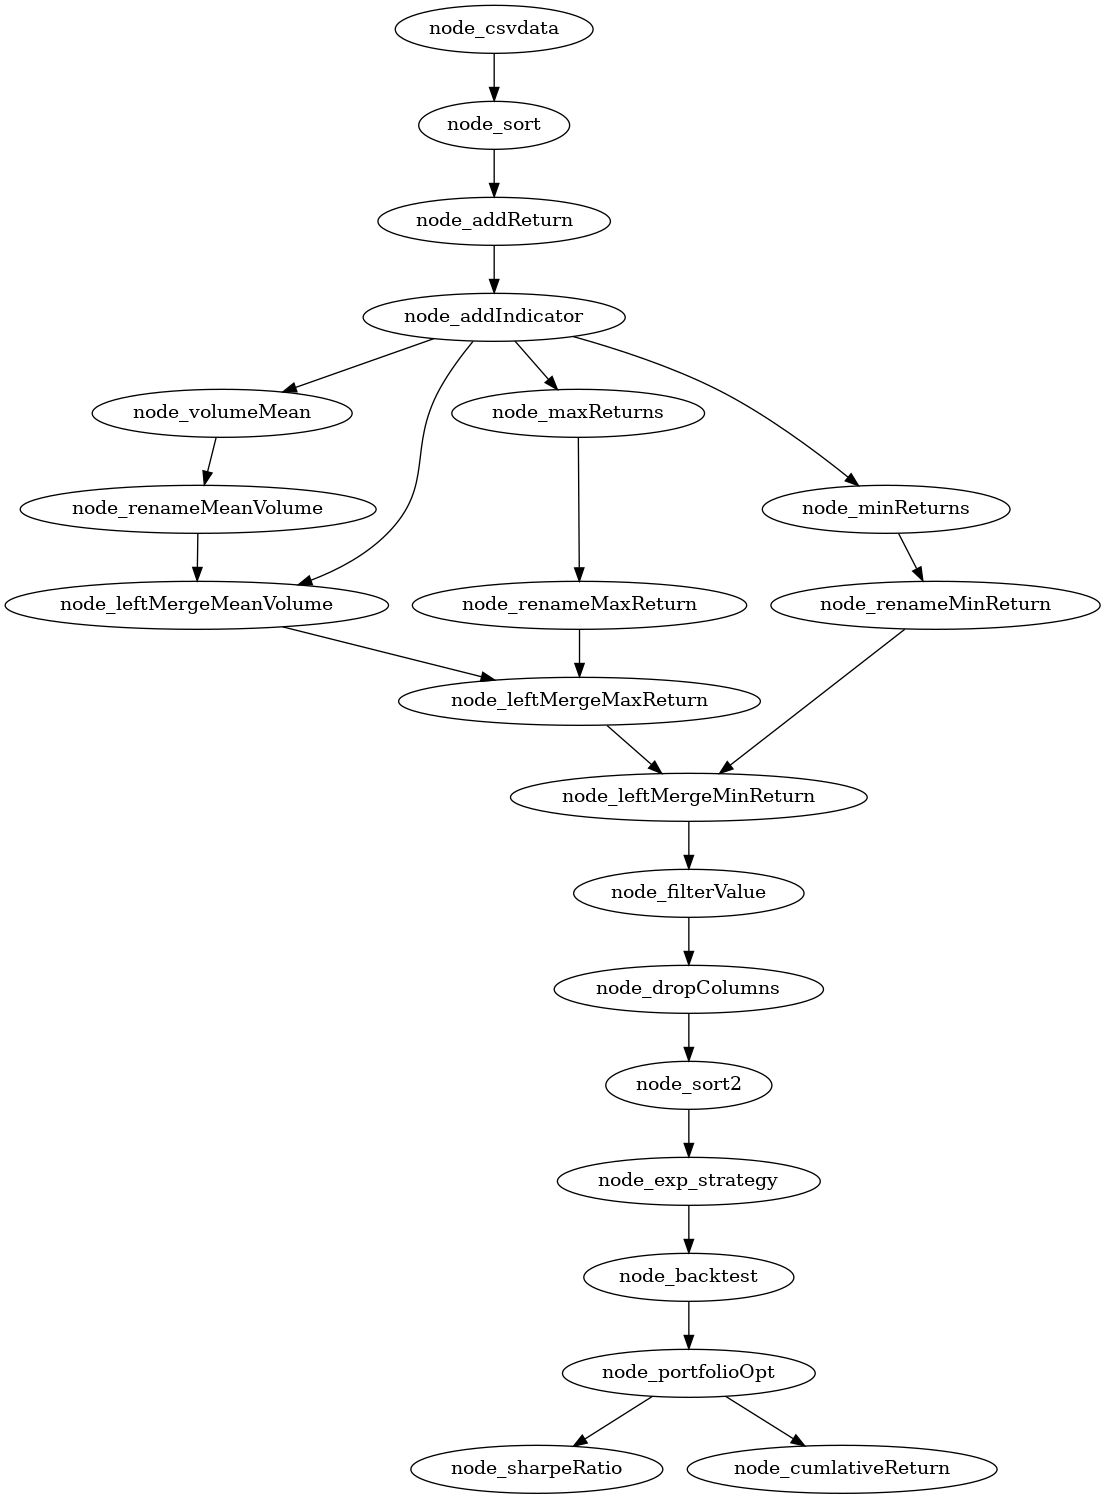

In [6]:
graph_obj = load_workflow('../task_example/port_trade.yaml')
G = viz_graph(graph_obj)
draw(G, show='ipynb')

From the graph, we notice that it is doing the 7 steps computation as we described above. 

### gQuant Node implementation
In gQuant, we implement a few common nodes that is useful for the quantitative finance. With the help of Numba library, we implemented 36 technical indicators that are used in computing trading signals and accelerated in the GPU. However, it is not the gQuant's goal to be comprehensive for quant applications. It provides a framework that is easy for anyone to implement his own nodes in the gQuant. Data scientists just need to override two functions: "process" and "columns_setup" in the parent class "Node". The "process" function is the main function that takes input dataframes and computes the output dataframe. The "columns_setup" is to define what are the required input dataframe column names and types, what are the output dataframe column names and types after the computation. In this way, the dataframes are strongly typed and the errors can be detected early before the time consuming computation happens. Here is the code example for implementing MaxNode, which is to compute the maximum value for a specified column in the dataframe.

In [7]:
class MaxNode(Node):

    def process(self, inputs):
        input_df = inputs[0]
        max_column = self.conf['column']
        volume_df = input_df[[max_column,
                              "asset"]].groupby(["asset"]).max().reset_index()
        volume_df.columns = ['asset', max_column]
        return volume_df

    def columns_setup(self):
        self.required = {"asset": "int64"}
        self.retention = {"@column": "float64",
                          "asset": "int64"}

It is straightforward to customize one Node in the gQuant as shown in the example above. In case that there is no direct dataframe method for a particular logic, Numba GPU kernel can be used to implement it. gQuant can automatically handle the complication of include this customized GPU kernel node into Dask computation graph at the framework level.

### gQuant Result and Benchmark
Similar to tensorflow, gQuant graph is evaluated by specifying the output nodes and input nodes replacement.

In [8]:
action = "load" if os.path.isfile('./.cache/node_csvdata.hdf5') else "save"
o_gpu = run(graph_obj,
            outputs=['node_sharpeRatio', 'node_cumlativeReturn',
                     'node_csvdata', 'node_sort2'],
            replace={'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     'node_csvdata': {action: True}})

gpu_input_cached = o_gpu[2]
strategy_cached = o_gpu[3]

cumulative return 6815 22


The parameters for "node_filterValue" Node are overridden in the 'input_replace' arguments. The outputs from 4 nodes in the graph are computed and saved into 'o_gpu' variable. We cached the 'node_csvdata' and 'node_sort2' results in the the variables for later use. 

After 'node_filterValue', the graph filter out the stocks that is not suitable for backtesting. Run following commands:

In [9]:
print(len(gpu_input_cached['asset'].unique()))
print(len(strategy_cached['asset'].unique()))

5052
1558


There are 5052 stocks loaded initially and 4598 stocks remaining after filtering. 

"bqplot" library is used to visualize the backtesting results in the JupyterLab notebooks. 

In [10]:
# define the function to format the plots
def plot_figures(o):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    sharpe_number = o[0]
    cum_return = o[1]
    cum_return.layout.height = figure_height
    cum_return.layout.width = figure_width
    cum_return.title = 'P & L %.3f' % (sharpe_number)
    return cum_return


plot_figures(o_gpu)

Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale(), side='left'), Axis(l…

This toy strategy gets a Sharpe ratio 1.6 without considering the transaction cost. Nice! 

Next, we are going to compare the performance difference between CPU and GPU. The same computation graph can be used to flow the CPU Pandas dataframe with a few changes:

1. the root node need to be changed to load the Pandas dataframe
2. a few computation nodes that use Numba GPU kernels need to be changed to use CPU implementations 

Those nodes that uses compatible dataframe API calls can be leaved as is. We can simply change the Node type in the graph to change the implementations:

In [11]:
print(len(gpu_input_cached['asset'].unique()))
print(len(strategy_cached['asset'].unique()))

5052
1558


In [12]:
o_cpu = run(graph_obj,
            outputs=['node_sharpeRatio', 'node_cumlativeReturn',
                     'node_csvdata'],
            replace={'node_csvdata': {"type": "PandasCsvStockLoader"},
                     'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     'node_addReturn': {"type": "CpuReturnFeatureNode"},
                     'node_addIndicator': {"type": "CpuAssetIndicatorNode"},
                     'node_exp_strategy': {"type": "CpuPortExpMovingAverageStrategyNode"}})
cpu_input_cached = o_cpu[2]
plot_figures(o_cpu)

cumulative return 6815 22


Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

It produces the exact same results as GPU version but much slower. All the above computation happens in the CPU Pandas Dataframe. To quantify the performance, we do the following experiment:

In [15]:
%%time
o_gpu = run(graph_obj,
            outputs=['node_sharpeRatio', 'node_cumlativeReturn'],
            replace={'node_csvdata': {"load": gpu_input_cached},
                     'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]}})

cumulative return 6815 22
CPU times: user 29 s, sys: 4.85 s, total: 33.9 s
Wall time: 2.54 s


In [15]:
%%time
o_cpu = run(graph_obj,
            outputs=['node_sharpeRatio', 'node_cumlativeReturn'],
            replace={'node_csvdata': {"type": "PandasCsvStockLoader",
                                      "load": cpu_input_cached},
                     'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                   {"column": "returns_max", "max": max_rate},
                                                   {"column": "returns_min", "min": min_rate}]},
                     'node_addReturn': {"type": "CpuReturnFeatureNode"},
                     'node_addIndicator': {"type": "CpuAssetIndicatorNode"},
                     'node_exp_strategy': {"type": "CpuPortExpMovingAverageStrategyNode"}})

cumulative return 6815 22
CPU times: user 4min 19s, sys: 58.3 s, total: 5min 17s
Wall time: 1min 17s


We run this in V100 Tesla GPU and Intel(R) Xeon(R) Gold 6148 CPU. It takes 73 seconds to run in the CPU and 4 seconds to run in the GPU. We get 67x speed up by using GPU dataframe. Note, the input nodes load the dataframes from the cache variables to save the disk IO time. 

gQuant distributed computation
Run this toy example in Dask distributed environment is super easy as gQuant operates at the dataframe level. We just need to swap cudf Dataframe to dask_cudf Dataframe. First we split the large dataframe into small pieces to be loaded by different workers in the cluster (this step is noly need if the dataset is not prepared yet)

In [ ]:
import dask.dataframe as dd
import os
os.makedirs('many-small', exist_ok=True)
dd.from_pandas(cpu_input_cached.set_index('asset'), npartitions=8).reset_index().to_csv('many-small/*.csv', index=False)

The distributed computation is turned on by changing the root node type:

In [14]:
o_dask = run(graph_obj,
             outputs=['node_sharpeRatio', 'node_cumlativeReturn'],
             replace={'node_csvdata': {"type": "DaskCsvStockLoader",
                                       "conf": {"path": "many-small"}},
                      'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                    {"column": "returns_max", "max": max_rate},
                                                    {"column": "returns_min", "min": min_rate}]}})

plot_figures(o_dask)

cumulative return 6815 22


Figure(axes=[Axis(label='Cumulative return', orientation='vertical', scale=LinearScale()), Axis(label='Time', …

Again, it produces the same results. However it is slow in the performance. Distributed computation only makes sense if we have a very large dataset that cannot be fit into one GPU. In this example, the dataset is small that can be loaded into on GPU. The between-GPU communication overhead dominates in the computation. We want to show that switching between single GPU vs distributed computation is very easy in gQuant.

### Strategy parameter search
Quantitative analyst usually need to explore different parameters for their trading strategy. The exploration process is an iterative process. gQuant help to speed up this by allowing using cached dataframe and evaluating the sub-graphs.

To find the optimal parameters for this toy mean reversion strategy, we only need the dataframe from "note_sort2" node, which is cached in the "strategy_cached" variable. Because the GPU computation is so fast, we can make the parameter exploration interactive in the JupyterLab notebook:

In [13]:
para_selector = widgets.IntRangeSlider(value=[10, 30],
                                       min=3,
                                       max=60,
                                       step=1,
                                       description="MA:",
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def para_selection(*stocks):
    with out:
        para1 = para_selector.value[0]
        para2 = para_selector.value[1]
        o = run(graph_obj,
                outputs=['node_sharpeRatio', 'node_cumlativeReturn'],
                replace={'node_sort2': {"load": strategy_cached},
                         'node_exp_strategy': {'conf':  {'fast': para1,
                                                         'slow': para2}},
                         'node_filterValue': {"conf": [{"column": "volume_mean", "min": min_volume},
                                                       {"column": "returns_max", "max": max_rate},
                                                       {"column": "returns_min", "min": min_rate}]}})

        figure_combo = plot_figures(o)
        w.children = (w.children[0], figure_combo,)


out = widgets.Output(layout={'border': '1px solid black'})
para_selector.observe(para_selection, 'value')
selectors = widgets.HBox([para_selector])
w = widgets.VBox([selectors])
w

### Conclusions
In this blog, we uses gQuant to do a simple trading strategy backtesting for 5000 stocks. This example shows that gQuant is designed to deal with the challenges that the data science is facing due to the large datasets and complicated data science models and workflows. Organizing the data at the graph level makes the workflow easy to understand and easy to maintain. We showed it is easy to implement a dataframe processing node in gQuant to adapt to any data science applications. We showed the dataframe agnostic feature of gQuant allows it to switch easily between cuDF, Pandas and Dask cuDf dataframes. The benefits of using GPU dataframe is huge compare to the CPU dataframe. In our toy example, we showed we can get 20x speed up. The more data are processed in the GPU, the more speed up we can get. The recent STAC A3 benchmark uses the similar GPU dataframe approach to do backtest in the GPU via customized Numba GPU kernels, achieving 6000x speedup.

Hopefully you find this blog useful for your quant applications. We love to hear your feedbacks!

In [ ]:
out